In [91]:
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install rouge

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec # Import the Word2Vec class from the gensim library
from sklearn.cluster import KMeans
from rouge import Rouge
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import pairwise_distances_argmin_min
from tqdm import tqdm
from gensim.models import KeyedVectors


In [4]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [69]:
w2v_model_path='/content/drive/MyDrive/Project/GoogleNews-vectors-negative300.bin.gz'
word2vec_model = KeyedVectors.load_word2vec_format(w2v_model_path, binary=True)

In [5]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [6]:
train_df = pd.read_csv('/content/drive/MyDrive/Project/train_data.csv')
validation_df = pd.read_csv('/content/drive/MyDrive/Project/validation_data.csv')

In [11]:
train_subset = train_df.sample(n=50000,random_state=42)
val_subset = validation_df.sample(n=500,random_state=42)

In [12]:
train_summaries = train_subset['highlights'].tolist()
val_summaries = val_subset['highlights'].tolist()

In [13]:
print(train_df.shape)
print(val_subset.shape)

(95705, 3)
(500, 3)


In [14]:
train_subset['article'].iloc[0]

'Washington (CNN) -- The Federal Emergency Management Agency has not attempted to recoup some $643 million in payments that were improperly given to 160,000 individuals for housing and other aid following Hurricanes Katrina and Rita, an independent government investigator says. In a letter to FEMA Administrator Craig Fugate, Inspector General Richard Skinner wrote that a federal court in 2008 ordered FEMA to change its process for recovering the money. But Monday, three years after that court ruling, "These payments remain uncollected because your office has not given final approval of a new recoupment process," Skinner wrote. Following the back-to-back storms in 2005, FEMA disbursed more than $7 billion in assistance to survivors. At the time, the government placed a premium on distributing the money quickly because of the dire needs of residents of the Gulf Coast. The money was intended for rental assistance, home repairs, housing replacement, moving costs, medical costs and other in

In [97]:
def preprocess_sentence(sentence):
    """
    Preprocess the sentence: tokenization, stop word removal, punctuation removal
    """
    text=re.sub(r'\W',' ', sentence)

    # Tokenize and remove punctuation and stop words
    tokens = word_tokenize(text.lower())
    return [word for word in tokens if word not in stop_words]




In [98]:
def sentence_to_vector(sentence, model):
    """
    Convert a sentence to a vector by averaging word vectors.
    """
    words = preprocess_sentence(sentence)
    word_vectors = []

    # Get word vectors for words in the sentence
    for word in words:
        if word in model.key_to_index:  # Check if the word is in the model's vocabulary
            word_vectors.append(model[word])

    # Return the average word vector for the sentence
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        # If no word vectors found, return a zero vector (for empty sentences or unknown words)
        return np.zeros(model.vector_size)

In [99]:
def calculate_sentence_similarity(sentences, model):
    """
    Calculate the cosine similarity between each pair of sentences based on their vectors.
    """
    # Convert each sentence to its vector representation
    sentence_vectors = np.array([sentence_to_vector(sentence, model) for sentence in sentences])

    # Compute the cosine similarity matrix
    similarity_matrix = cosine_similarity(sentence_vectors)
    return similarity_matrix

In [109]:
def extractive_summary(text, model, top_n=3):
    """
    Generate an extractive summary by selecting top N sentences based on cosine similarity.
    """
    sentences = text.split('.')  # Split text into sentences (adjust this if needed)
    similarity_matrix = calculate_sentence_similarity(sentences, model)

    # Get similarity scores for each sentence (using the first sentence as a reference)
    similarity_scores = similarity_matrix[0]  # Assuming first sentence as the reference

    # Rank sentences by similarity scores
    sorted_similarities = sorted(enumerate(similarity_scores), key=lambda x: x[1], reverse=True)

    # Extract top N sentences
    top_sentences = [sentences[idx] for idx, _ in sorted_similarities[:top_n]]
    return '.'.join(top_sentences)


In [110]:
# For validation data
validation_summaries = []
for idx, row in validation_df.iterrows():
    text = row['article']  # Replace with your text column name
    summary = extractive_summary(text, word2vec_model, top_n=3)  # Extract top 3 sentences for the summary
    validation_summaries.append(summary)

In [111]:
# Add the summary to the validation DataFrame
validation_df['summary'] = validation_summaries

In [112]:
val_summaries = validation_df['highlights'].tolist()  # Replace with the column for reference summaries
w2v_val_summaries = validation_df['summary'].tolist()

In [113]:
rouge = Rouge()
w2v_scores = rouge.get_scores(w2v_val_summaries, val_summaries)


KeyboardInterrupt: 

In [107]:
w2v_scores[:10]

[{'rouge-1': {'r': 0.15, 'p': 0.058823529411764705, 'f': 0.08450703820670522},
  'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0},
  'rouge-l': {'r': 0.1, 'p': 0.0392156862745098, 'f': 0.056338024122198266}},
 {'rouge-1': {'r': 0.17857142857142858,
   'p': 0.09090909090909091,
   'f': 0.12048192323994793},
  'rouge-2': {'r': 0.037037037037037035,
   'p': 0.015625,
   'f': 0.02197801780461376},
  'rouge-l': {'r': 0.14285714285714285,
   'p': 0.07272727272727272,
   'f': 0.09638553769777927}},
 {'rouge-1': {'r': 0.325, 'p': 0.16883116883116883, 'f': 0.22222221772225886},
  'rouge-2': {'r': 0.07142857142857142,
   'p': 0.034482758620689655,
   'f': 0.04651162351541416},
  'rouge-l': {'r': 0.275, 'p': 0.14285714285714285, 'f': 0.18803418353422466}},
 {'rouge-1': {'r': 0.5294117647058824, 'p': 0.125, 'f': 0.2022471879207171},
  'rouge-2': {'r': 0.17647058823529413,
   'p': 0.03488372093023256,
   'f': 0.058252424428315706},
  'rouge-l': {'r': 0.4117647058823529,
   'p': 0.09722222222222222,
   'f'

In [114]:
validation_df['summary'][0]

'(CNN)Share, and your gift will be multiplied. But the power that multiplied Broussard\'s gift was data processing of genetic profiles from donor-recipient pairs. "I thought I was going to help this one person who I don\'t know, but the fact that so many people can have a life extension, that\'s pretty big," Broussard told CNN affiliate KGO'

In [115]:
validation_df['highlights'][0]

'Zully Broussard decided to give a kidney to a stranger . A new computer program helped her donation spur transplants for six kidney patients .'

In [70]:
def preprocess_text(text):
    # Basic text cleaning
    text=re.sub(r'\W',' ', text)

    # Sentence tokenization
    sentences = sent_tokenize(text)
    processed_sentences = []

    lemmatizer = WordNetLemmatizer()
    # Word tokenization and stopword removal
    for sentence in sentences:
        words = word_tokenize(sentence.lower())
        words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
        processed_sentences.append(words)

    return sentences, processed_sentences

In [71]:
len(train_subset['article'])

50000

In [72]:
# train_subset['processed_w2v'] = [preprocess_text(article) for article in tqdm(train_subset['article'])]


In [73]:
# tokenized_sentences = [tokens for _, tokenized in train_subset['processed_w2v'] for tokens in tokenized]


In [74]:
# word2vec_model = Word2Vec(sentences=tokenized_sentences, vector_size=100, window=5, min_count=5, workers=4, sg=1)


In [78]:
# Function to get sentence vectors using trained Word2Vec model
def get_sentence_vector(sentence_tokens, model):
    # Filter tokens present in the model vocabulary
    valid_words = [word for word in sentence_tokens if word in model.key_to_index]
    # print(valid_words[0])
    if not valid_words:  # If no valid words found, return a zero vector
        return np.zeros(model.vector_size)
    # Average word vectors
    return np.mean([model[word] for word in valid_words], axis=0)

In [90]:
# Step 3: Generate extractive summaries for validation data
def generate_summary(article_text, model, num_clusters=3):
    original_sentences, tokenized_sentences = preprocess_text(article_text)

    # Generate sentence embeddings
    sentence_vectors = [get_sentence_vector(tokens, model) for tokens in tokenized_sentences]
    print(sentence_vectors)
    # Handle cases where the article has no valid embeddings or too few sentences
    if len(sentence_vectors) < num_clusters:  # Check if there are enough sentences for clustering
        # Adjust the number of clusters if needed or return a message
        num_clusters = len(sentence_vectors)  # Set to number of sentences or
        # Handle the case where num_clusters is still 0 (e.g., return a default summary)
        if num_clusters == 0:
            return "No valid summary generated."

    # Apply K-Means Clustering
    num_clusters = min(num_clusters, len(original_sentences))  # Ensure we do not exceed the number of sentences
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    kmeans.fit(sentence_vectors)
    labels = kmeans.labels_

    # Select representative sentences
    centroids = kmeans.cluster_centers_
    print("Cluster Labels:", labels)
    print("Cluster Centroids:", centroids)
    summary_sentences = []
    for cluster_idx in range(num_clusters):
      print(cluster_idx)
      cluster_indices = [i for i, label in enumerate(labels) if label == cluster_idx]
      closest_sentence_idx = min(cluster_indices, key=lambda i: cosine_similarity([sentence_vectors[i]], [centroids[cluster_idx]])[0][0])
      print(closest_sentence_idx)
      if cosine_similarity([sentence_vectors[closest_sentence_idx]], [centroids[cluster_idx]])[0][0] > 0.7:
        summary_sentences.append(original_sentences[closest_sentence_idx])
    # Debugging: Print selected sentences
    print("Selected Sentences:", summary_sentences)
    # Form the summary
    summary = ' '.join(summary_sentences)
    return summary

In [89]:
len(generate_summary(val_subset['article'].iloc[0], word2vec_model, num_clusters=3))

[array([ 2.45729703e-02,  4.07117754e-02,  1.21344496e-02,  7.13021830e-02,
       -4.12015244e-02, -2.00570934e-02,  3.68186235e-02, -9.70847383e-02,
        9.49523002e-02,  6.74088076e-02, -8.37543234e-03, -1.34518772e-01,
       -2.18899623e-02,  1.27270278e-02, -6.77682608e-02,  7.78269395e-02,
        2.64469665e-02,  1.10385217e-01, -2.89281718e-02, -6.47669807e-02,
       -1.57074574e-02,  5.23842759e-02,  5.05668186e-02, -1.50051070e-02,
       -3.67872324e-03, -6.35621995e-02, -1.13384180e-01,  8.60137418e-02,
        3.75532769e-02, -5.38135543e-02, -1.57158840e-02,  2.08740985e-05,
       -3.24921533e-02, -2.66983192e-02, -3.21899774e-03, -1.67676304e-02,
        4.48458195e-02,  2.82340776e-02,  3.64034995e-02,  6.72216415e-02,
        2.46841162e-02, -5.46235330e-02,  1.17003098e-01,  1.33318845e-02,
        3.41858133e-03, -5.25664352e-02, -3.53006385e-02, -2.88358945e-02,
       -1.26036303e-03,  2.49213986e-02, -4.00024205e-02,  1.87716614e-02,
        1.53982341e-02, 

4407

In [38]:
len(val_subset['article'].iloc[0])

4409

In [ ]:
# # Function to preprocess the text
# def preprocess_text(text):

#     # Step 1: Convert text to lowercase
#     text = text.lower()

#     # Step 2: Remove special characters, numbers, and extra spaces
#     text = re.sub(r'\W',' ',text)

#     # Step 3: Tokenize sentences and words
#     words = word_tokenize(text)

#     # Step 4: Remove stopwords and perform lemmatization
#     processed_words = [lemmatizer.lemmatize(word) for word in words
#                        if word not in stop_words]

#     # Return cleaned text as a single string
#     return ' '.join(processed_words)

In [ ]:
# # Function to split text into sentences
# def split_into_sentences(text):
#     return sent_tokenize(text)

In [ ]:
# train_sentences

In [ ]:
# Preprocess the training summaries
train_cleaned_texts = [preprocess_text(text) for text in train_summaries]

# Function to split text into sentences
def split_into_sentences(text):
    return sent_tokenize(text)

# Tokenize sentences from preprocessed text
train_sentences = []
for text in train_cleaned_texts:
    train_sentences.extend(split_into_sentences(text))


In [ ]:
# Tokenize sentences into words for Word2Vec training
train_tokenized_sentences = [word_tokenize(sent) for sent in train_sentences]

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=train_tokenized_sentences, vector_size=100, window=5, min_count=1, workers=4)


In [ ]:
# Function to generate sentence embeddings
def sentence_embedding(sentence, model):
    embeddings = []
    words = word_tokenize(sentence)
    for word in words:
        if word in model.wv:
            embeddings.append(model.wv[word])

    # Average word embeddings to get sentence embedding
    return np.mean(embeddings, axis=0) if embeddings else np.zeros(model.vector_size)

# Create embeddings for all sentences
sentence_embeddings = np.array([sentence_embedding(sent, word2vec_model) for sent in train_sentences])


In [ ]:
# Function to find the optimal number of clusters using the Elbow Method
def plot_elbow_method(sentence_embeddings, max_k=10):
    inertia_values = []
    k_values = range(1, max_k + 1)

    # Calculate inertia for each k value
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(sentence_embeddings)
        inertia_values.append(kmeans.inertia_)

    # Plot the results
    plt.figure(figsize=(8, 5))
    plt.plot(k_values, inertia_values, marker='o', linestyle='--', color='b')
    plt.title('Elbow Method for Optimal k')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia (Sum of Squared Distances)')
    plt.xticks(k_values)
    plt.grid()
    plt.show()

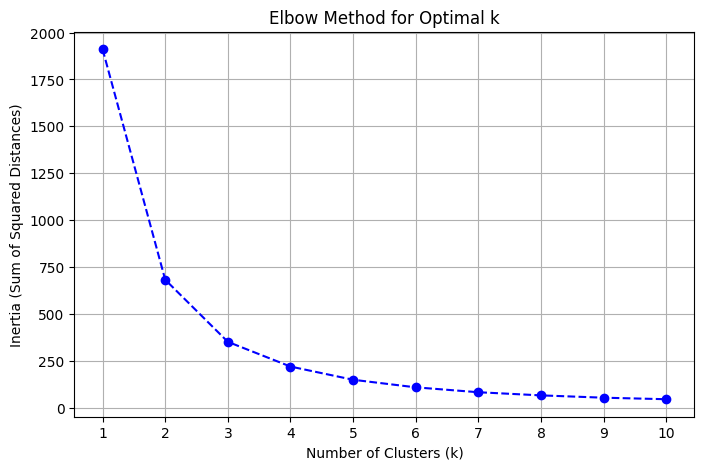

In [ ]:
plot_elbow_method(sentence_embeddings, max_k=10)


In [ ]:
# Define the number of clusters (you can tune this value)
num_clusters = 5  # Example: you can change this based on the dataset size

# KMeans clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(sentence_embeddings)

KMeans(n_clusters=5, random_state=42)

In [ ]:
# Extract representative sentences from clusters
def extract_summary(sentences, sentence_embeddings, kmeans):
    # Get the closest sentence to each cluster center
    closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, sentence_embeddings)
    summary_sentences = [sentences[idx] for idx in sorted(closest)]
    return ' '.join(summary_sentences)

# Generate summary
extracted_summary = extract_summary(train_sentences, sentence_embeddings, kmeans)
print("Extracted Summary:")
print(extracted_summary)


Extracted Summary:
new case time move parent attorney say rachel canning 18 sued mother father financial support college tuition returned home last wednesday alleged forced leavehome parent said left david frum young people overwhelmingly support sex marriage say bigger question future marriage general younger american increasingly choosing get married frum child born single parent face much longer odds life uk bank ever shed many job corporate history banking giant hsbc say also axing 750 post cull take total job loss lloyd 40 000 since 2009 promise branch closure majority loss managerial level norad two f 16 dispatched friday report unruly passenger aboard airtran flight passenger belligerent leave bathroom airline spokesman say atlanta san francisco flight diverted colorado spring colorado fighter escorted jet bound hawaii back oregon wednesday similar scenario colt gone winless without injured starting quarterback peyton manning manning led team unprecedented success super bowl cha

In [ ]:
def preprocess_text(text):

    text = re.sub(r'\W',' ',text)

    # Sentence tokenization
    sentences = sent_tokenize(text)
    processed_sentences = []

    # Word tokenization and stopword removal
    for sentence in sentences:
        words = word_tokenize(sentence.lower())
        words = [word for word in words if word.isalpha() and word not in stop_words]
        processed_sentences.append(words)

    return sentences, processed_sentences

In [ ]:
# Apply preprocessing on the training data
print("Preprocessing articles...")
train_df['processed'] = train_df['article'].apply(preprocess_text)

Preprocessing articles...


In [ ]:
# Extract tokenized sentences for Word2Vec training
tokenized_sentences = [tokens for _, tokenized in train_df['processed'] for tokens in tokenized]


In [ ]:
# Step 2: Train Word2Vec model on the training data
print("Training Word2Vec model...")
word2vec_model = Word2Vec(sentences=tokenized_sentences, vector_size=100, window=5, min_count=5, workers=4, sg=1)


Training Word2Vec model...


In [ ]:
# Function to get sentence vectors using trained Word2Vec model
def get_sentence_vector(sentence_tokens, model):
    # Filter tokens present in the model vocabulary
    valid_words = [word for word in sentence_tokens if word in model.wv.key_to_index]
    if not valid_words:  # If no valid words found, return a zero vector
        return np.zeros(model.vector_size)
    # Average word vectors
    return np.mean([model.wv[word] for word in valid_words], axis=0)

In [ ]:
# Step 3: Generate extractive summaries for validation data
def generate_summary(article_text, model, num_clusters=3):
    original_sentences, tokenized_sentences = preprocess_text(article_text)

    # Generate sentence embeddings
    sentence_vectors = [get_sentence_vector(tokens, model) for tokens in tokenized_sentences]

    # Handle cases where the article has no valid embeddings
    if len(sentence_vectors) == 0 or np.sum(np.array(sentence_vectors)) == 0:
        return "No valid summary generated."

    # Apply K-Means Clustering
    num_clusters = min(num_clusters, len(original_sentences))  # Ensure we do not exceed the number of sentences
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    kmeans.fit(sentence_vectors)
    labels = kmeans.labels_

    # Select representative sentences
    centroids = kmeans.cluster_centers_
    summary_sentences = []
    for cluster_idx in range(num_clusters):
        cluster_indices = [i for i, label in enumerate(labels) if label == cluster_idx]
        closest_sentence_idx = min(cluster_indices, key=lambda i: cosine_similarity([sentence_vectors[i]], [centroids[cluster_idx]])[0][0])
        summary_sentences.append(original_sentences[closest_sentence_idx])

    # Form the summary
    summary = ' '.join(summary_sentences)
    return summary

In [ ]:
# Step 4: Generate summaries and evaluate on validation data
print("Generating summaries for validation data...")
val_subset['generated_summary'] = val_subset['article'].apply(lambda x: generate_summary(x, word2vec_model))


Generating summaries for validation data...


In [ ]:
rouge = Rouge()


In [ ]:
val_subset['generated_summary'].iloc[0]

'A woman has sparked uproar on social media after enthusiastically bearing her K cup breasts on Google Street View  Karen Davis from Port Pirie in South Australia was captured streaking by the Google camera cars for the popular Google Maps app  which allows users to zoom in on certain streets and towns in cities all over the world with a 360 degree view  However the 38 year old mother  who plans to skydive topless for her 40th birthday  has hit back at  flat tittie chicks  claiming they are not confident enough with their own bodies and should focus on how they look  Karen Davis  pictured  from Port Pirie has caused controversy after a picture appeared on Google Maps Street View showing her bearing her size K breasts   In the image  Ms Davis can be seen holding her arms up in the air with her T shirt hunched up around her neck bearing her breasts  as she follows the Google camera cars around the street  Her sons are playing in the background and an unknown man stands at the fence watch

In [ ]:
val_summaries[0]

"A woman has caused a social media storm after bearing her boobs . The Port Pirie woman showed her size-K assets on Google Street View . She has been called a 'bad mother' by people from her town . Karen Davis says they are 'not happy with their own bodies' She plans to do a topless skydive for her 40th birthday next year ."

In [ ]:
val_subset['article'].iloc[0]

"A woman has sparked uproar on social media after enthusiastically bearing her K-cup breasts on Google Street View. Karen Davis from Port Pirie in South Australia was captured streaking by the Google camera cars for the popular Google Maps app, which allows users to zoom in on certain streets and towns in cities all over the world with a 360-degree view. However the 38-year-old mother, who plans to skydive topless for her 40th birthday, has hit back at 'flat-tittie chicks' claiming they are not confident enough with their own bodies and should focus on how they look. Karen Davis (pictured) from Port Pirie has caused controversy after a picture appeared on Google Maps Street View showing her bearing her size-K breasts . In the image, Ms Davis can be seen holding her arms up in the air with her T-shirt hunched up around her neck bearing her breasts, as she follows the Google camera cars around the street. Her sons are playing in the background and an unknown man stands at the fence watch